In [1]:
import numpy as np
import pandas as pd

import pickle as pkl

import gc
from sklearn.model_selection import KFold
from cuml.metrics import mean_absolute_error, mean_squared_error

import seaborn as sns

In [2]:
out_base_path = '/media/hiroki/working/kaggle/trends-neuroimaging/models'

In [3]:
OUTPUT_DICT = ''

ID = 'Id'
TARGET_COLS = ['age', 'domain1_var1', 'domain1_var2', 'domain2_var1', 'domain2_var2']
SEED = 2020

N_FOLD = 15

In [4]:
base_path = '/media/hiroki/share/kaggle_data/trends-assessment-prediction/'
train = pd.read_csv(base_path+'train_scores.csv', dtype={'Id':str})\
            #.dropna().reset_index(drop=True) # to make things easy
reveal_ID = pd.read_csv(base_path+'reveal_ID_site2.csv', dtype={'Id':str})
ICN_numbers = pd.read_csv(base_path+'ICN_numbers.csv')
loading = pd.read_csv(base_path+'loading.csv', dtype={'Id':str})
fnc = pd.read_csv(base_path+'fnc.csv', dtype={'Id':str})
sample_submission = pd.read_csv(base_path+'sample_submission.csv', dtype={'Id':str})

In [5]:
fnc_features, loading_features = list(fnc.columns[1:]), list(loading.columns[1:])

In [6]:
sample_submission['ID_num'] = sample_submission[ID].apply(lambda x: int(x.split('_')[0]))
test = pd.DataFrame({ID: sample_submission['ID_num'].unique().astype(str)})
del sample_submission['ID_num']; gc.collect()
test.head()

,Id
0,10003
1,10006
2,10010
3,10011
4,10012


In [7]:
test.head()

,Id
0,10003
1,10006
2,10010
3,10011
4,10012


In [8]:
# merge
train = train.merge(loading, on=ID, how='left')
train = train.merge(fnc, on=ID, how='left')
train

,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2,IC_01,IC_07,IC_05,IC_16,...,CBN(13)_vs_DMN(94),CBN(18)_vs_DMN(94),CBN(4)_vs_DMN(94),CBN(7)_vs_DMN(94),CBN(18)_vs_CBN(13),CBN(4)_vs_CBN(13),CBN(7)_vs_CBN(13),CBN(4)_vs_CBN(18),CBN(7)_vs_CBN(18),CBN(7)_vs_CBN(4)
0,10001,57.436077,30.571975,62.553736,53.325130,51.427998,0.006070,0.014466,0.004136,0.000658,...,-0.149279,0.552841,0.131046,0.335446,0.394867,-0.042853,0.124627,-0.060712,0.515964,0.290488
1,10002,59.580851,50.969456,67.470628,60.651856,58.311361,0.009087,0.009291,0.007049,-0.002076,...,-0.214216,-0.039792,0.143014,-0.189962,0.498373,0.444231,0.592438,0.028649,0.705524,0.248327
2,10004,71.413018,53.152498,58.012103,52.418389,62.536641,0.004675,0.000957,0.006154,-0.000429,...,-0.130339,0.309540,0.141469,0.030853,0.344394,0.214097,0.317556,0.012435,0.665937,0.081358
3,10005,66.532630,NaN,NaN,52.108977,69.993075,-0.000398,0.006878,0.009051,0.000369,...,-0.139525,0.394932,0.040443,0.428334,0.498837,0.266755,0.227379,0.028984,0.752343,0.087898
4,10007,38.617381,49.197021,65.674285,40.151376,34.096421,0.005192,0.010585,0.012160,-0.000920,...,-0.150218,0.408926,0.072004,0.157582,0.532046,0.355448,0.462675,0.161005,0.703679,0.293607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5872,21746,14.257265,21.358872,61.165998,51.778483,54.640179,-0.001115,0.007108,0.008652,0.003596,...,-0.249481,0.205351,0.012067,0.310750,0.426335,0.193812,0.158720,0.055471,0.568766,0.160516
5873,21747,55.456978,68.169675,29.907995,55.349257,54.019517,0.007263,0.016489,0.012704,0.004357,...,-0.119170,0.201846,-0.008290,0.119828,0.551936,0.598931,0.511816,0.303312,0.704483,0.461588
5874,21750,48.948756,55.114811,60.878271,38.617246,50.679885,0.005996,0.003873,0.012353,0.000242,...,-0.103786,0.375065,0.104857,0.262614,0.502715,0.322353,0.458041,0.343754,0.705207,0.341224
5875,21752,66.532630,59.844808,72.303110,55.458281,46.870235,0.000627,0.011407,0.010957,0.000534,...,0.229712,0.431489,0.039062,0.119474,0.523894,0.445209,0.332011,0.228977,0.560968,0.263504


In [9]:
# merge
test = test.merge(loading, on=ID, how='left')
test = test.merge(fnc, on=ID, how='left')
test

,Id,IC_01,IC_07,IC_05,IC_16,IC_26,IC_06,IC_10,IC_09,IC_18,...,CBN(13)_vs_DMN(94),CBN(18)_vs_DMN(94),CBN(4)_vs_DMN(94),CBN(7)_vs_DMN(94),CBN(18)_vs_CBN(13),CBN(4)_vs_CBN(13),CBN(7)_vs_CBN(13),CBN(4)_vs_CBN(18),CBN(7)_vs_CBN(18),CBN(7)_vs_CBN(4)
0,10003,0.008151,0.014684,0.010444,-0.005293,-0.002913,0.015042,0.017745,0.003930,-0.008021,...,-0.154941,0.136850,-0.022361,0.137625,0.677972,0.409412,0.563892,0.438684,0.618204,0.284474
1,10006,0.000334,0.005311,0.010053,0.006920,-0.000065,0.015310,0.016543,0.004794,0.003982,...,-0.053606,0.240957,0.270419,0.367692,0.354501,0.486364,0.416908,0.285274,0.693490,0.448526
2,10010,0.007103,0.006144,0.009770,-0.002884,-0.001346,0.015651,0.011613,-0.003291,0.013423,...,-0.244332,0.272077,0.193523,0.192254,0.563982,0.124482,0.488926,0.083368,0.774299,0.129327
3,10011,0.004362,0.010240,0.010167,0.004492,-0.001623,0.017381,0.014680,0.007453,0.008786,...,-0.099726,0.557121,0.042626,0.179456,0.416546,0.445402,0.436909,0.165182,0.591561,0.306678
4,10012,-0.007521,-0.003918,0.008434,-0.001145,0.002017,0.015065,0.019616,0.004140,-0.003744,...,-0.025230,0.203298,0.173427,0.046047,0.561599,0.418268,0.609517,0.218285,0.790285,0.301010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5872,21745,0.005406,0.006275,0.012252,0.003518,0.001400,0.015054,0.015373,0.001532,0.003546,...,0.179080,0.580813,0.202241,0.254870,0.458581,0.434638,0.587167,0.009854,0.472956,0.342085
5873,21748,0.004240,0.009213,0.010981,0.000443,-0.003072,0.010702,0.014673,0.005523,0.005780,...,-0.106345,0.234340,0.138985,0.343382,0.708744,0.312812,0.536501,0.214803,0.849512,0.204741
5874,21749,0.004783,0.017910,0.012128,-0.005683,-0.011613,0.017000,0.007230,0.001315,0.008788,...,-0.165575,0.170154,-0.029638,0.383761,0.398305,0.578621,0.357127,0.009479,0.609545,0.317230
5875,21751,0.003835,0.015067,0.015428,-0.002030,0.001205,0.012396,0.011026,-0.001491,0.005310,...,-0.087604,0.131902,-0.047932,0.022317,0.583869,0.596734,0.515209,0.379589,0.568422,0.439016


In [10]:
import IPython

def display(*dfs, head=True):
    for df in dfs:
        IPython.display.display(df.head() if head else df)

In [11]:
def metric(y_true, y_pred):
    return np.mean(np.sum(np.abs(y_true - y_pred), axis=0)/np.sum(y_true, axis=0))

In [12]:
# Giving less importance to FNC features since they are easier to overfit due to high dimensionality.
#FNC_SCALE = 1/600

#train[fnc_features] *= FNC_SCALE
#test[fnc_features] *= FNC_SCALE

In [13]:
# 学習データに対する「目的変数を知らない」予測値と、テストデータに対する予測値を返す関数
def predict_cv(train_x, train_y, test_x, model, target_name):
    preds = []
    preds_test = []
    va_idxes = []
    
    score = []
    mae = []
    rmse = []

    # shuffleしなくても良い
    kf = KFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

    # クロスバリデーションで学習・予測を行い、予測値とインデックスを保存する
    for i, (tr_idx, va_idx) in enumerate(kf.split(train_x)):
        tr_x, va_x = train_x.iloc[tr_idx].values, train_x.iloc[va_idx].values
        tr_y, va_y = train_y.iloc[tr_idx].values, train_y.iloc[va_idx].values
        model.fit(tr_x, tr_y)
        pred = model.predict(va_x)
        preds.append(pred)
        pred_test = model.predict(test_x)
        preds_test.append(pred_test)
        va_idxes.append(va_idx)
        
        score.append(metric(va_y, pred))
        mae.append(mean_absolute_error(va_y, pred))
        rmse.append(np.sqrt(mean_squared_error(va_y, pred)))
        
    score_cv = np.array(score).mean()
    mae_cv = np.array(mae).mean()
    rmse_cv = np.array(rmse).mean()
    print("{0}_score:{1}".format(target_name, np.round(score_cv, 8)))
    print("{0}_mae:{1}".format(target_name, np.array(mae_cv).mean()))
    print("{0}_rmse:{1}".format(target_name, np.array(rmse_cv).mean()))
    # バリデーションデータに対する予測値を連結し、その後元の順序に並べ直す
    va_idxes = np.concatenate(va_idxes)
    preds = np.concatenate(preds, axis=0)
    order = np.argsort(va_idxes)
    pred_train = preds[order]

    # テストデータに対する予測値の平均をとる
    preds_test = np.mean(preds_test, axis=0)

    return pred_train, preds_test, score_cv

# 1st layer

## SVR

In [14]:
import cudf
import cupy as cp
from cuml import SVR

In [15]:
with open(out_base_path + '/1st_layer/svm/svm_train.pkl', 'rb') as f:
  pred_train_targets_svr_dfs = pkl.load(f)

with open(out_base_path + '/1st_layer/svm/svm_test.pkl', 'rb') as f:
  pred_test_targets_svr_dfs = pkl.load(f)

In [16]:
for i, pred_df in enumerate(pred_train_targets_svr_dfs.values()):
    if i == 0:
        pred_train_dfs = pred_df
        #display(pred_train_dfs, head=False)
    else:
        pred_train_dfs = pd.concat([pred_train_dfs, pred_df.drop("Id", axis=1)], axis=1)
        #display(pred_train_dfs, head=False)

In [17]:
for i, pred_df in enumerate(pred_test_targets_svr_dfs.values()):
    if i == 0:
        pred_test_dfs = pred_df
        #display(pred_test_dfs, head=False)
    else:
        pred_test_dfs = pd.concat([pred_test_dfs, pred_df.drop("Id", axis=1)], axis=1)
        #display(pred_test_dfs, head=False)

## baysian ridge

In [18]:
with open(out_base_path + '/1st_layer/bayes_ridge/bayes_ridge_train.pkl', 'rb') as f:
  pred_train_targets_bayes_ridge_dfs = pkl.load(f)

with open(out_base_path + '/1st_layer/bayes_ridge/bayes_ridge_test.pkl', 'rb') as f:
  pred_test_targets_bayes_ridge_dfs = pkl.load(f)

In [19]:
for i, pred_df in enumerate(pred_train_targets_bayes_ridge_dfs.values()):
    pred_train_dfs = pd.concat([pred_train_dfs, pred_df.drop("Id", axis=1)], axis=1)

for i, pred_df in enumerate(pred_test_targets_bayes_ridge_dfs.values()):
    pred_test_dfs = pd.concat([pred_test_dfs, pred_df.drop("Id", axis=1)], axis=1)

In [20]:
pred_train_dfs

,Id,pre_svr_age,pre_svr_domain1_var1,pre_svr_domain1_var2,pre_svr_domain2_var1,pre_svr_domain2_var2,pre_bayRidge_age,pre_bayRidge_domain1_var1,pre_bayRidge_domain1_var2,pre_bayRidge_domain2_var1,pre_bayRidge_domain2_var2
0,10001,60.877768,53.299463,59.728622,49.506853,50.245806,60.906731,53.632844,58.933031,48.193288,50.639470
1,10002,55.056918,54.708045,59.462757,48.809679,52.669451,56.150469,53.087283,59.347237,47.758491,52.007702
2,10004,51.727589,51.827130,60.177994,47.702372,50.088077,52.027515,52.085337,58.739435,46.646664,50.433512
3,10005,61.276086,NaN,NaN,50.182354,54.036360,60.813771,NaN,NaN,48.631294,51.899048
4,10007,44.009071,49.981281,58.200460,46.080720,52.361837,43.660350,49.480579,59.537922,46.166929,52.333379
...,...,...,...,...,...,...,...,...,...,...,...
5872,21746,33.566653,50.700319,60.844463,45.499232,50.331900,34.199012,50.407656,59.896793,45.761590,49.912153
5873,21747,51.158271,48.903705,58.519688,47.681367,54.147085,51.591765,48.533070,58.785206,48.017085,52.178250
5874,21750,40.541940,49.380542,62.664363,46.724739,53.457566,41.323194,49.492569,59.906589,46.374749,51.902514
5875,21752,55.981565,54.848841,58.994825,48.854849,54.597196,55.273854,55.548991,59.230211,48.076530,52.063537


In [21]:
#with open(out_base_path + '/1st_layer/bayes_ridge_pc_ica/bayes_ridge_train.pkl', 'rb') as f:
#  pred_train_targets_bayes_ridge_dfs_PC_IC = pkl.load(f)

#with open(out_base_path + '/1st_layer/bayes_ridge_pc_ica/bayes_ridge_test.pkl', 'rb') as f:
#  pred_test_targets_bayes_ridge_dfs_PC_IC = pkl.load(f)

In [22]:
#for i, pred_df in enumerate(pred_train_targets_bayes_ridge_dfs_PC_IC.values()):
#    pred_train_dfs = pd.concat([pred_train_dfs, pred_df.drop("Id", axis=1)], axis=1)
    
#for i, pred_df in enumerate(pred_test_targets_bayes_ridge_dfs_PC_IC.values()):
#    pred_test_dfs = pd.concat([pred_test_dfs, pred_df.drop("Id", axis=1)], axis=1)

## BaggingRegressor

In [23]:
with open(out_base_path + '/1st_layer/bagging_ridge/bagging_ridge_train.pkl', 'rb') as f:
  pred_train_targets_bagging_ridge_dfs = pkl.load(f)

with open(out_base_path + '/1st_layer/bagging_ridge/bagging_ridge_test.pkl', 'rb') as f:
  pred_test_targets_bagging_ridge_dfs = pkl.load(f)

In [24]:
for i, pred_df in enumerate(pred_train_targets_bagging_ridge_dfs.values()):
    pred_train_dfs = pd.concat([pred_train_dfs, pred_df.drop("Id", axis=1)], axis=1)

for i, pred_df in enumerate(pred_test_targets_bagging_ridge_dfs.values()):
    pred_test_dfs = pd.concat([pred_test_dfs, pred_df.drop("Id", axis=1)], axis=1)

In [25]:
#with open(out_base_path + '/1st_layer/bagging_ridge_pc_ica/bagging_ridge_train.pkl', 'rb') as f:
#  pred_train_targets_bagging_ridge_dfs_PC_IC = pkl.load(f)

#with open(out_base_path + '/1st_layer/bagging_ridge_pc_ica/bagging_ridge_test.pkl', 'rb') as f:
#  pred_test_targets_bagging_ridge_dfs_PC_IC = pkl.load(f)

In [26]:
#for i, pred_df in enumerate(pred_train_targets_bagging_ridge_dfs_PC_IC.values()):
#    pred_train_dfs = pd.concat([pred_train_dfs, pred_df.drop("Id", axis=1)], axis=1)
#for i, pred_df in enumerate(pred_test_targets_bagging_ridge_dfs_PC_IC.values()):
#    pred_test_dfs = pd.concat([pred_test_dfs, pred_df.drop("Id", axis=1)], axis=1)

# LightGBM

In [27]:
#with open(out_base_path + '/1st_layer/lgb_pc_and_raw/lgb_train.pkl', 'rb') as f:
  #pred_train_targets_lgb_dfs = pkl.load(f)

#with open(out_base_path + '/1st_layer/lgb_pc_and_raw/lgb_test.pkl', 'rb') as f:
  #pred_test_targets_lgb_dfs = pkl.load(f)

In [28]:
#for i, pred_df in enumerate(pred_train_targets_lgb_dfs.values()):
    #pred_train_dfs = pd.concat([pred_train_dfs, pred_df.drop("Id", axis=1)], axis=1)

#for i, pred_df in enumerate(pred_test_targets_lgb_dfs.values()):
    #pred_test_dfs = pd.concat([pred_test_dfs, pred_df.drop("Id", axis=1)], axis=1)

In [29]:
with open(out_base_path + '/1st_layer/lgb_fncPC_and_loadingIC_and_raw/lgb_train.pkl', 'rb') as f:
  pred_train_targets_lgb_dfs_PC_IC = pkl.load(f)

with open(out_base_path + '/1st_layer/lgb_fncPC_and_loadingIC_and_raw/lgb_test.pkl', 'rb') as f:
  pred_test_targets_lgb_dfs_PC_IC = pkl.load(f)

In [30]:
for i, pred_df in enumerate(pred_train_targets_lgb_dfs_PC_IC.values()):
    pred_train_dfs = pd.concat([pred_train_dfs, pred_df.drop("Id", axis=1)], axis=1)

for i, pred_df in enumerate(pred_test_targets_lgb_dfs_PC_IC.values()):
    pred_test_dfs = pd.concat([pred_test_dfs, pred_df.drop("Id", axis=1)], axis=1)

In [31]:
pred_train_dfs.columns

Index(['Id', 'pre_svr_age', 'pre_svr_domain1_var1', 'pre_svr_domain1_var2',
       'pre_svr_domain2_var1', 'pre_svr_domain2_var2', 'pre_bayRidge_age',
       'pre_bayRidge_domain1_var1', 'pre_bayRidge_domain1_var2',
       'pre_bayRidge_domain2_var1', 'pre_bayRidge_domain2_var2',
       'pre_bagRidge_age', 'pre_bagRidge_domain1_var1',
       'pre_bagRidge_domain1_var2', 'pre_bagRidge_domain2_var1',
       'pre_bagRidge_domain2_var2', 'pre_lgb_PCICraw_age',
       'pre_lgb_PCICraw_domain1_var1', 'pre_lgb_PCICraw_domain1_var2',
       'pre_lgb_PCICraw_domain2_var1', 'pre_lgb_PCICraw_domain2_var2'],
      dtype='object')

# GPR

In [32]:
gpr_path = '/media/hiroki/working/kaggle/trends-neuroimaging/models/1st_layer/GPR_ICA'
pred_train_gpr = pd.read_csv(gpr_path + '/gpr_train.csv')
pred_test_gpr = pd.read_csv(gpr_path + '/gpr_test.csv')

In [33]:
pred_train_gpr.drop("Id", axis=1, inplace=True)
pred_test_gpr.drop("Id", axis=1, inplace=True)

In [34]:
std_columns = list(pred_train_gpr.loc[
        :, pred_train_gpr.columns.str.contains('std')
    ].columns)

In [35]:
pred_train_dfs = pd.concat([pred_train_dfs, pred_train_gpr], axis=1)
pred_test_dfs = pd.concat([pred_test_dfs, pred_test_gpr], axis=1)

In [36]:
gpr_path_fs = '/media/hiroki/working/kaggle/trends-neuroimaging/models/1st_layer/GPR_FeatureSelection'
pred_train_gpr_fs = pd.read_csv(gpr_path_fs + '/gpr_train.csv')
pred_test_gpr_fs = pd.read_csv(gpr_path_fs + '/gpr_test.csv')

In [37]:
pred_train_gpr_fs.drop("Id", axis=1, inplace=True)
pred_test_gpr_fs.drop("Id", axis=1, inplace=True)
pred_train_dfs = pd.concat([pred_train_dfs, pred_train_gpr_fs], axis=1)
pred_test_dfs = pd.concat([pred_test_dfs, pred_test_gpr_fs], axis=1)

# Ridge

In [38]:
ridge_path = '/media/hiroki/working/kaggle/trends-neuroimaging/models/1st_layer/ridge'
pred_train_ridge = pd.read_csv(ridge_path + '/valid_ridge_No2.csv')
pred_test_ridge = pd.read_csv(ridge_path + '/test_ridge_No2.csv')

In [39]:
pred_train_dfs = pd.concat([pred_train_dfs, pred_train_ridge], axis=1)
pred_test_dfs = pd.concat([pred_test_dfs, pred_test_ridge], axis=1)

# k-NN

In [40]:
knr_path = '/media/hiroki/working/kaggle/trends-neuroimaging/models/1st_layer/knr'
pred_train_knr = pd.read_csv(knr_path + '/train_knr.csv')
pred_test_knr = pd.read_csv(knr_path + '/test_knr.csv')

In [41]:
age_columns = list(pred_train_knr.loc[
        :, pred_train_knr.columns.str.contains('age')
    ].columns)

In [42]:
pred_train_knr.drop(age_columns, axis=1, inplace=True)
pred_test_knr.drop(age_columns, axis=1, inplace=True)

In [43]:
#pred_train_dfs = pd.concat([pred_train_dfs, pred_train_knr], axis=1)
#pred_test_dfs = pd.concat([pred_test_dfs, pred_test_knr], axis=1)

# LGB pred_sum

In [44]:
#lgb_path = '/media/hiroki/working/kaggle/trends-neuroimaging/models/1st_layer/lgb_pred_SUM_target'
#pred_train_lgb_sum = pd.read_csv(lgb_path + '/lgb_pred_sum_train.csv', dtype={'Id':str})
#pred_test_lgb_sum = pd.read_csv(lgb_path + '/lgb_pred_sum_test.csv', dtype={'Id':str})

In [45]:
#pred_train_dfs = pred_train_dfs.merge(pred_train_lgb_sum, on=ID, how='left')
#pred_test_dfs = pred_test_dfs.merge(pred_test_lgb_sum, on=ID, how='left')

In [46]:
#pred_train_dfs

# 2nd layer

In [47]:
#std = ['pre_gpr_std_age',
#       'pre_gpr_std_domain1_var1', 'pre_gpr_std_domain1_var2',
#       'pre_gpr_std_domain2_var1', 'pre_gpr_std_domain2_var2']

In [48]:
pred_train_dfs = pd.concat([pred_train_dfs, train[TARGET_COLS]], axis=1)

In [49]:
pred_train_dfs.shape

(5877, 52)

# BayesianRidge

In [50]:
from sklearn.linear_model import BayesianRidge

In [51]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

In [52]:
layer2_pred_train_targets_bayes_ridge = {}
layer2_pred_test_targets_bayes_ridge = {}

layer2_pred_train_targets_bayes_ridge_dfs = {}
layer2_pred_test_targets_bayes_ridge_dfs = {}

overal_score = 0

print("N_FOLD:{}".format(N_FOLD))

for target, w in [("age", 0.3),
                  ("domain1_var1", 0.175),
                  ("domain1_var2", 0.175),
                  ("domain2_var1", 0.175),
                  ("domain2_var2", 0.175)]:
    target_columns = list(pred_train_dfs.loc[
        :, pred_train_dfs.columns.str.contains('_'+target)
    ].columns)
    
    train_df2 = pred_train_dfs[pred_train_dfs[target].notnull()]
    use_idx = train_df2.index
    train_x_2 = train_df2[target_columns]
    ss.fit(train_x_2)
    train_x_2 = ss.fit_transform(train_x_2)
    train_x_2 = pd.DataFrame(train_x_2)
    
    train_y = train_df2[target]
    
    test_df2 = pred_test_dfs
    test_x_2 = test_df2[target_columns]
    test_x_2 = ss.fit_transform(test_x_2)
    test_x_2 = pd.DataFrame(test_x_2)
    
    bayes_ridge = BayesianRidge(n_iter = 3000)
    
    print("-----{}-----".format(target))
    pred_train, preds_test, score_cv = predict_cv(train_x_2, train_y, test_x_2, bayes_ridge, target)
    overal_score += w*score_cv
    layer2_pred_train_targets_bayes_ridge[target] = pred_train
    layer2_pred_test_targets_bayes_ridge[target] = preds_test
    
    layer2_pred_train_targets_bayes_ridge_dfs[target] = pd.Series(pred_train, name="pre_bayRidge_2{}".format(target), index=use_idx)
    layer2_pred_train_targets_bayes_ridge_dfs[target] = pd.merge(train['Id'],
                                                 pred_train_targets_bayes_ridge_dfs[target],
                                                 left_index=True,
                                                 right_index=True)
    layer2_pred_test_targets_bayes_ridge_dfs[target] = pd.Series(preds_test, name="pre_bayRidge_2{}".format(target))
    layer2_pred_test_targets_bayes_ridge_dfs[target] = pd.concat([test['Id'], pred_test_targets_bayes_ridge_dfs[target]], axis=1)

    
    
print('--------------------------------------------')
print("Overal score:", np.round(overal_score, 8))

N_FOLD:15
-----age-----
age_score:0.14132382
age_mae:7.070162313277667
age_rmse:8.972562467976944
-----domain1_var1-----
domain1_var1_score:0.15069668
domain1_var1_mae:7.757882683635996
domain1_var1_rmse:9.657085270014559
-----domain1_var2-----
domain1_var2_score:0.15088582
domain1_var2_mae:8.93755685348203
domain1_var2_rmse:11.346645862473624
-----domain2_var1-----
domain2_var1_score:0.18108911
domain2_var1_mae:8.567802980119954
domain2_var1_rmse:10.85147040479642
-----domain2_var2-----
domain2_var2_score:0.17609503
domain2_var2_mae:9.13719201099101
domain2_var2_rmse:11.66692288548436
--------------------------------------------
Overal score: 0.15768131


In [53]:
N_FOLD:15
-----age-----
age_score:0.14211619
age_mae:7.10980556428282
age_rmse:9.02625445314305
-----domain1_var1-----
domain1_var1_score:0.15074528
domain1_var1_mae:7.7603435443157505
domain1_var1_rmse:9.660564557385378
-----domain1_var2-----
domain1_var2_score:0.15092853
domain1_var2_mae:8.940088357181613
domain1_var2_rmse:11.34736590075671
-----domain2_var1-----
domain2_var1_score:0.18125127
domain2_var1_mae:8.57551305041878
domain2_var1_rmse:10.858421423459847
-----domain2_var2-----
domain2_var2_score:0.17611619
domain2_var2_mae:9.138458749118092
domain2_var2_rmse:11.664251886321214
--------------------------------------------
Overal score: 0.15796708

SyntaxError: invalid syntax (<ipython-input-53-64ae7983809a>, line 2)

In [ ]:
Overal score: 0.15835412 -> Overal score: 0.15814395 -> Overal score: 0.15808592 -> 0.15796708 -> 0.15773632-> 0.15768131

In [ ]:
layer2_pred_train_targets_bayes_ridge_dfs = {}
layer2_pred_test_targets_bayes_ridge_dfs

In [ ]:
layer2_pred_train_targets_bayes_ridge

In [54]:
for df in layer2_pred_train_targets_bayes_ridge_dfs.values():
    display(df.describe())
#pred_train_targets_df = pd.DataFrame(layer2_pred_train_targets_bayes_ridge)
pred_test_targets_df = pd.DataFrame(layer2_pred_test_targets_bayes_ridge)

,pre_bayRidge_age
count,5877.000000
mean,50.038717
std,10.038128
min,19.518356
25%,42.842211


,pre_bayRidge_domain1_var1
count,5439.000000
mean,51.492404
std,3.185482
min,40.796837
25%,49.327597


,pre_bayRidge_domain1_var2
count,5439.000000
mean,59.245596
std,0.645455
min,56.373948
25%,58.836050


,pre_bayRidge_domain2_var1
count,5838.000000
mean,47.321834
std,2.256074
min,40.439732
25%,45.751823


,pre_bayRidge_domain2_var2
count,5838.000000
mean,51.903249
std,1.865373
min,40.634094
25%,50.685836


In [55]:
for df in layer2_pred_train_targets_bayes_ridge_dfs.values():
    display(df.describe())
#pred_train_targets_df = pd.DataFrame(layer2_pred_train_targets_bayes_ridge)
pred_test_targets_df = pd.DataFrame(layer2_pred_test_targets_bayes_ridge)

,pre_bayRidge_age
count,5877.000000
mean,50.038717
std,10.038128
min,19.518356
25%,42.842211


,pre_bayRidge_domain1_var1
count,5439.000000
mean,51.492404
std,3.185482
min,40.796837
25%,49.327597


,pre_bayRidge_domain1_var2
count,5439.000000
mean,59.245596
std,0.645455
min,56.373948
25%,58.836050


,pre_bayRidge_domain2_var1
count,5838.000000
mean,47.321834
std,2.256074
min,40.439732
25%,45.751823


,pre_bayRidge_domain2_var2
count,5838.000000
mean,51.903249
std,1.865373
min,40.634094
25%,50.685836


# lgb

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl

import gc
from sklearn.model_selection import KFold
from cuml.metrics import mean_absolute_error, mean_squared_error

import seaborn as sns

import lightgbm as lgb

In [57]:
#with open (out_base_path+'/2nd_layer/bayes_ridge/ver2/bayes_ridge_train2.pkl', 'wb') as f:
  #pkl.dump(layer2_pred_test_targets_bayes_ridge_dfs , f)

#with open (out_base_path+'/2nd_layer/bayes_ridge/ver2/bayes_ridge_test2.pkl', 'wb') as f:
 # pkl.dump(pred_test_targets_bagging_ridge_dfs , f)

In [58]:
# 学習データに対する「目的変数を知らない」予測値と、テストデータに対する予測値を返す関数
def predict_cv_lgb(train_x, train_y, test_x, target_name, param):
    preds = []
    preds_test = []
    va_idxes = []
    
    score = []
    mae = []
    rmse = []
    
    features = train_x.columns
    # shuffleしなくても良い
    kf = KFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)
    # クロスバリデーションで学習・予測を行い、予測値とインデックスを保存する
    for i, (tr_idx, va_idx) in enumerate(kf.split(train_x)):
        tr_x, va_x = train_x.iloc[tr_idx].values, train_x.iloc[va_idx].values
        tr_y, va_y = train_y.iloc[tr_idx].values, train_y.iloc[va_idx].values
        
        lgb_train = lgb.Dataset(tr_x, tr_y)
        lgb_val = lgb.Dataset(va_x, va_y)
        
        num_round = 100000
        
        clf = lgb.train(param,
                       lgb_train,
                       num_round,
                       valid_sets=[lgb_train, lgb_val],
                       verbose_eval=False,
                       early_stopping_rounds=1000)
        
        pred = clf.predict(va_x, num_iteration=clf.best_iteration)
        preds.append(pred)
        pred_test = clf.predict(test_x, num_iteration=clf.best_iteration)
        preds_test.append(pred_test)
        va_idxes.append(va_idx)
        
        score.append(metric(va_y, pred))
        mae.append(mean_absolute_error(va_y, pred))
        rmse.append(np.sqrt(mean_squared_error(va_y, pred)))

        fold_importance_df = pd.DataFrame()
        fold_importance_df["Feature"] = features
        fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
        fold_importance_df["fold"] = i+1
        if i == 0:
            feature_importance_df = fold_importance_df
        else:
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
    score_cv = np.array(score).mean()
    mae_cv = np.array(mae).mean()
    rmse_cv = np.array(rmse).mean()
    print("{0}_score:{1}".format(target_name, np.round(score_cv, 8)))
    print("{0}_mae:{1}".format(target_name, np.array(mae_cv).mean()))
    print("{0}_rmse:{1}".format(target_name, np.array(rmse_cv).mean()))
    # バリデーションデータに対する予測値を連結し、その後元の順序に並べ直す
    va_idxes = np.concatenate(va_idxes)
    preds = np.concatenate(preds, axis=0)
    order = np.argsort(va_idxes)
    pred_train = preds[order]

    # テストデータに対する予測値の平均をとる
    preds_test = np.mean(preds_test, axis=0)

    return pred_train, preds_test, score_cv, feature_importance_df

In [59]:
lgb_param = {'objective': 'regression',
             'metric': 'rmse',
             'boosting_type': 'gbdt',
             "learning_rate" : 0.01,
             "num_leaves" : 13,
             "bagging_freq": 5,
             "bagging_fraction" : 0.4,
             "feature_fraction" : 0.05,
             "tree_learner": "serial",
             "boost_from_average": "false",
             "min_data_in_leaf": 80,
             "bagging_seed" : SEED,
             'seed': SEED,
             'max_depth': 3,
             "num_leaves" : 13,
             'verbosity': -1,
            }

In [60]:
def show_feature_importance(feature_importance_df, name):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False).index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

    plt.figure(figsize=(8, 16))
    sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Features importance (averaged/folds)')
    plt.tight_layout()
    plt.savefig(OUTPUT_DICT+f'feature_importance_{name}_pca.png')

N_FOLD:15
-----age-----
age_score:0.14187835
age_mae:7.097701100379052
age_rmse:8.983100524382795
-----domain1_var1-----
domain1_var1_score:0.15103229
domain1_var1_mae:7.775264415466029
domain1_var1_rmse:9.666896084120115
-----domain1_var2-----
domain1_var2_score:0.15156754
domain1_var2_mae:8.977912446952121
domain1_var2_rmse:11.3704638792236
-----domain2_var1-----
domain2_var1_score:0.18108849
domain2_var1_mae:8.56767644554014
domain2_var1_rmse:10.850014142970078
-----domain2_var2-----
domain2_var2_score:0.17704519
domain2_var2_mae:9.186244141754374
domain2_var2_rmse:11.68078243246981
--------------------------------------------
Overal score: 0.15819187


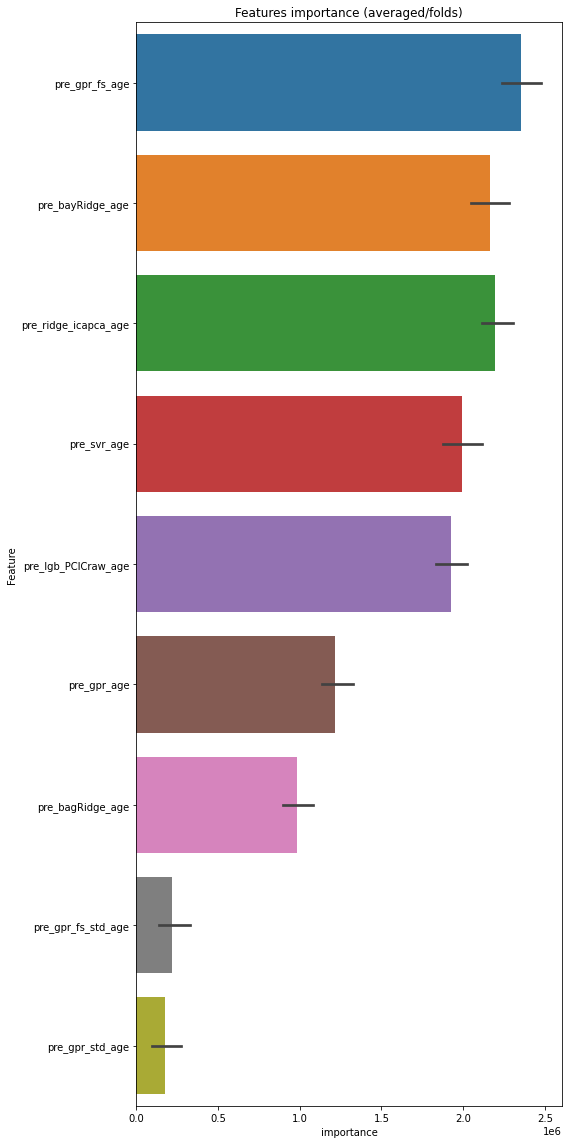

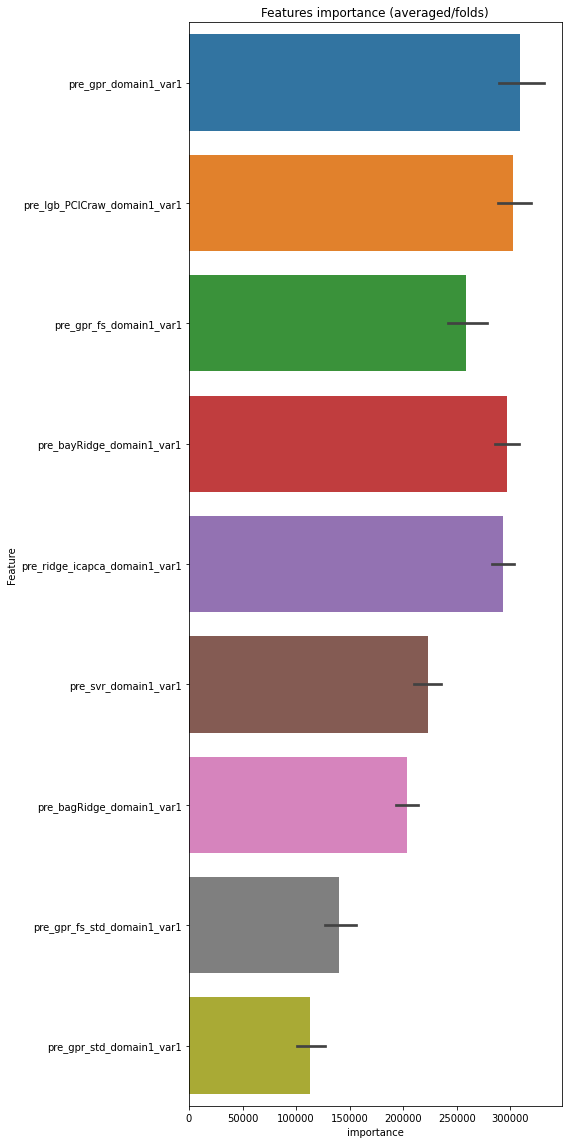

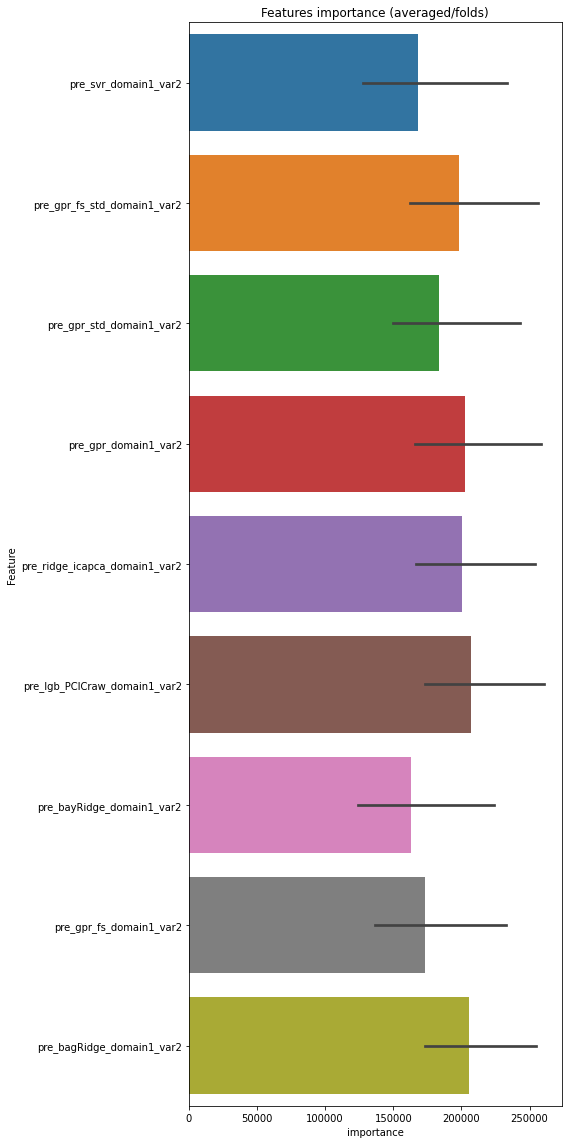

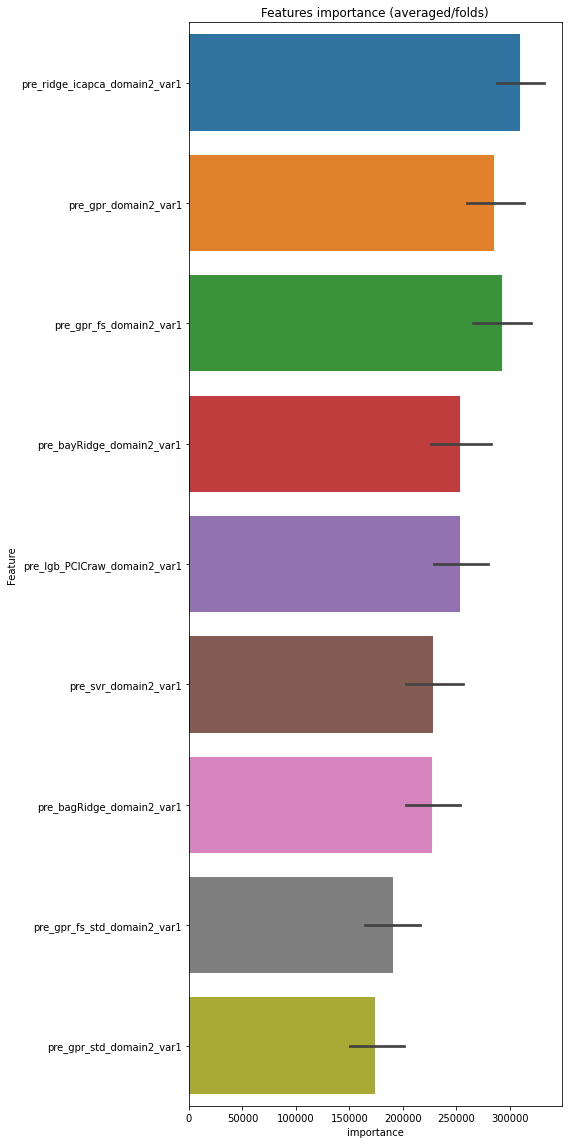

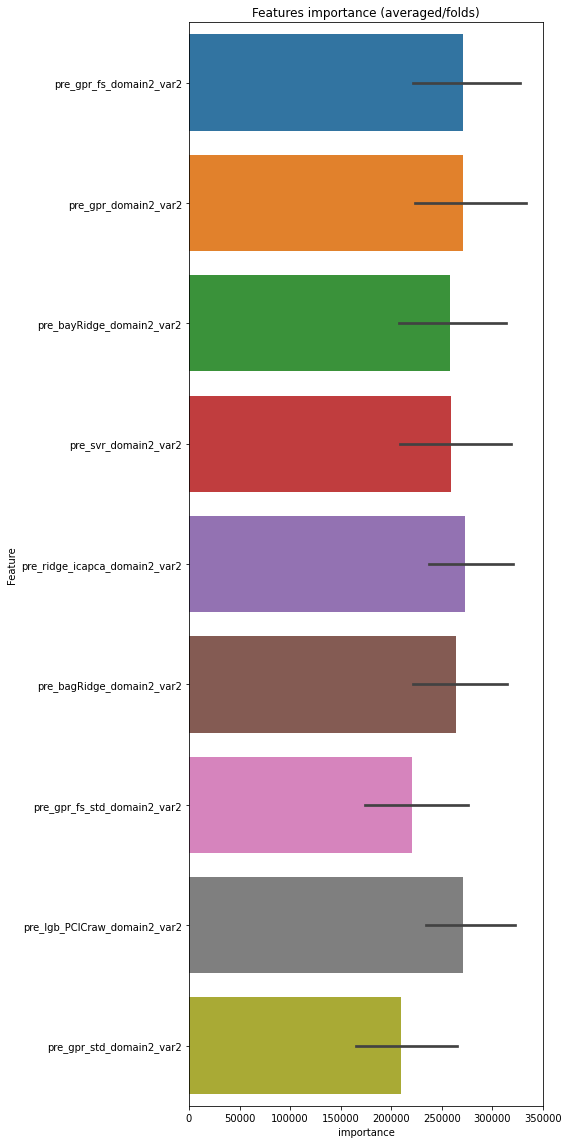

In [61]:
layer2_pred_train_targets_lgb = {}
layer2_pred_test_targets_lgb = {}

layer2_pred_train_targets_lgb_dfs = {}
layer2_pred_test_targets_lgb_dfs = {}

overal_score = 0

print("N_FOLD:{}".format(N_FOLD))

for target, w in [("age", 0.3),
                  ("domain1_var1", 0.175),
                  ("domain1_var2", 0.175),
                  ("domain2_var1", 0.175),
                  ("domain2_var2", 0.175)]:
    target_columns = list(pred_train_dfs.loc[
        :, pred_train_dfs.columns.str.contains('_'+target)
    ].columns)
    
    train_df2 = pred_train_dfs[pred_train_dfs[target].notnull()]
    use_idx = train_df2.index
    train_x_2 = train_df2[target_columns]
    ss.fit(train_x_2)
    #train_x_2 = ss.fit_transform(train_x_2)
    #train_x_2 = pd.DataFrame(train_x_2)
    
    train_y = train_df2[target]
    
    test_df2 = pred_test_dfs
    test_x_2 = test_df2[target_columns]
    #test_x_2 = ss.fit_transform(test_x_2)
    #test_x_2 = pd.DataFrame(test_x_2)
    
    print("-----{}-----".format(target))
    pred_train, preds_test, score_cv, fi = predict_cv_lgb(train_x=train_x_2,
                                                          train_y=train_y,
                                                          test_x=test_x_2,
                                                          target_name=target,
                                                          param=lgb_param)
    show_feature_importance(fi, target)
    overal_score += w*score_cv
    layer2_pred_train_targets_lgb[target] = pred_train
    layer2_pred_test_targets_lgb[target] = preds_test
    
    layer2_pred_train_targets_lgb_dfs[target] = pd.Series(pred_train, name="pre_lgb_2{}".format(target), index=use_idx)
    layer2_pred_train_targets_lgb_dfs[target] = pd.merge(train['Id'],
                                                 layer2_pred_train_targets_lgb_dfs[target],
                                                 left_index=True,
                                                 right_index=True)
    layer2_pred_test_targets_lgb_dfs[target] = pd.Series(preds_test, name="pre_lgb_2{}".format(target))
    layer2_pred_test_targets_lgb_dfs[target] = pd.concat([test['Id'], layer2_pred_test_targets_lgb_dfs[target]], axis=1)

    
    
print('--------------------------------------------')
print("Overal score:", np.round(overal_score, 8))

In [ ]:
N_FOLD:15
-----age-----
age_score:0.14276881
age_mae:7.142316300932006
age_rmse:9.028329896880477
-----domain1_var1-----
domain1_var1_score:0.1513409
domain1_var1_mae:7.7910279241380636
domain1_var1_rmse:9.683627849645118
-----domain1_var2-----
domain1_var2_score:0.15168961
domain1_var2_mae:8.985089126132364
domain1_var2_rmse:11.37556589320008
-----domain2_var1-----
domain2_var1_score:0.18142767
domain2_var1_mae:8.583642787613751
domain2_var1_rmse:10.868442716726836
-----domain2_var2-----
domain2_var2_score:0.17718602
domain2_var2_mae:9.193739371801911
domain2_var2_rmse:11.68763580724886
--------------------------------------------
Overal score: 0.15861838

# Submit

In [56]:
test_df = pd.concat([test['Id'], pred_test_targets_df], axis=1)

In [57]:
test_df.describe()

,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
count,5877.000000,5877.000000,5877.000000,5877.000000,5877.000000
mean,50.034504,51.474088,59.244054,47.326688,51.905794
std,10.158748,3.257885,0.912794,2.480516,2.126706
min,19.702907,40.150050,55.543664,39.379745,40.035552
25%,42.487387,49.218285,58.630373,45.564253,50.458504
50%,49.775192,51.506152,59.272880,47.276363,51.837828
75%,57.219079,53.723653,59.871395,49.012948,53.289722
max,82.718338,62.659133,63.663288,60.683284,60.298273


In [60]:
#test_df.to_csv('/media/hiroki/working/kaggle/trends-neuroimaging/models/submit/stacking_pre_test_ver5.csv')

In [59]:
sub_df = pd.melt(test_df[["Id", "age", "domain1_var1", "domain1_var2", "domain2_var1", "domain2_var2"]], id_vars=["Id"], value_name="Predicted")
sub_df["Id"] = sub_df["Id"].astype("str") + "_" +  sub_df["variable"].astype("str")

sub_df = sub_df.drop("variable", axis=1).sort_values("Id")
assert sub_df.shape[0] == test_df.shape[0]*5
sub_df.head(10)

,Id,Predicted
0,10003_age,55.902642
5877,10003_domain1_var1,49.200854
11754,10003_domain1_var2,59.148796
17631,10003_domain2_var1,50.885196
23508,10003_domain2_var2,57.237863
1,10006_age,64.254109
5878,10006_domain1_var1,54.149473
11755,10006_domain1_var2,58.769609
17632,10006_domain2_var1,49.073594
23509,10006_domain2_var2,51.950258


In [61]:
#sub_df.to_csv('/media/hiroki/working/kaggle/trends-neuroimaging/models/submit/submit_ver5.csv', index=False)